<a href="https://colab.research.google.com/github/whyeon92/ESAA_OB/blob/Code_Study/ESAA_HW0906.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
# 뒤에 플롯 그릴 때 제대로 안나와서 폰트 설치 과정 추가.
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

!apt-get install -qq fonts-nanum
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fm.fontManager.addfont(font_path)
plt.rc('font', family='NanumGothic')

Selecting previously unselected package fonts-nanum.
(Reading database ... 123597 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


# 3.1 MNIST

In [33]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version = 1, as_frame=False)
mnist.keys()

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

MNIST: 머신러닝계의 `Hello World`로 불릴정도로 자주 나오는, 손으로 쓴 7만 개의 숫자 이미지를 모아둔 데이터 셋.  
`sklearn.datasets`의 `fetch_openml`에서 불러올 수 있음. 아래의 코드로!
```
from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784", version = 1)
X, y = mnist['data'], mnist['target']
```


In [34]:
X, y = mnist['data'], mnist['target']
#한 셀에서 결과 내려고 프린트 사용했습니다
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


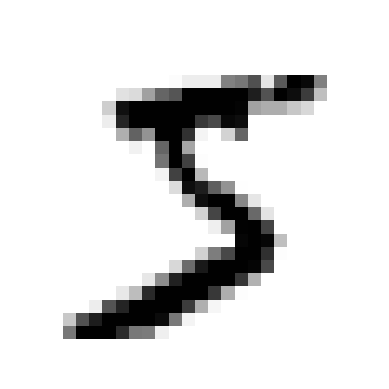

In [35]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = 'binary')
plt.axis("off")
plt.show()

imshow 함수로 이미지 출력

In [36]:
y[0]

'5'

In [37]:
#numpy 안불러서 오류나서 부름
import numpy as np
y = y.astype(np.uint8)

In [38]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

훈련 세트 이미 섞여 있어서 모든 교차 검증 폴드를 비슷하게 만듦.  
-> 특정 레이블이 Fold에 없거나 하면 안되니까 이미 적절히 분배된 상태 그대로 쓰는 듯?

# 3.2 이진 분류기 훈련

In [39]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [40]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [41]:
sgd_clf.predict([some_digit])

array([ True])

y_train == 5로 해서 0, 1로 이진 분류 시행

# 3.3 성능 측정

## 3.3.1 교차 검증을 사용한 정확도 측정

In [42]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits = 3)

for train_index, test_index in skfolds.split(X_train, y_train_5):
  #clone으로 모델 복사
  clone_clf = clone(sgd_clf)

  #stratified fold로 나뉜 인덱스에 따라서 X_train, y_train, X_test, y_test split 진행
  X_train_folds = X_train[train_index]
  y_train_folds = y_train_5[train_index]
  X_test_fold = X_train[test_index]
  y_test_fold = y_train_5[test_index]

  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred = clone_clf.predict(X_test_fold)
  n_correct = sum(y_pred == y_test_fold)
  print(n_correct / len(y_pred))  #정확도 출력

0.95035
0.96035
0.9604


In [43]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [44]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
  def fit(self, X, y = None):
    return self

  def predict(self, X):
    return np.zeros((len(X), 1), dtype = bool)
    #입력된 크기만큼 0을 반환, 전부 0으로 예측하게 만드는 함수

In [45]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

array([0.91125, 0.90855, 0.90915])

교차 검증을 통한 정확도 확인.  
⚠️생각보다 정확도가 굉장히 높음!  
-> 애초에 불균형한 데이터이기 때문에 하나로만 찍어도 거의 다 맞음...  
Never5Classifier를 활용해서 전부 0으로 만든 결과를 확인하니 오히려 이 때의 정확도도 거의 0.9를 웃돌게 됨.  
-> 정확도가 항상 좋은 성능 평가 지표는 아니다!!

## 3.3.2 오차 행렬

In [46]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)

In [47]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [48]:
y_train_perfect_predictions = y_train_5  #완벽한 분류기인 경우 가정
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

- TN (True Negative) : 0으로 예측, 실제값도 0
- FP (False Positive) : 1로 예측했는데 실제값은 0
- FN (False Negative) : 0으로 예측했는데 실제값은 1
- TP (True positive): 1로 예측, 실제로도 1

## 3.3.3 정밀도와 재현율

In [49]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [50]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [51]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

위에서 본 정확도의 허점으로 인해서 확인하는 게 오차 행렬 + 정밀도, 재현율. 각각 케이스에 따라 사용하는 바가 다르지만 둘 다 적당히 높은 게 제일 좋은 성능이라고 볼 수 있다.

## 3.3.4 정밀도/재현율 트레이드오프

In [52]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [53]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [54]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [55]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3,
                             method = "decision_function")

In [56]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


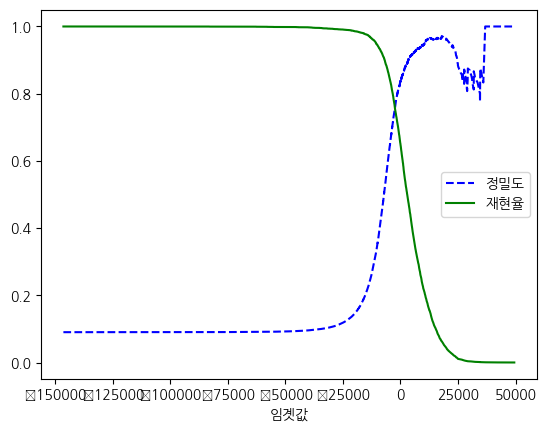

In [57]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], "b--", label = "정밀도")
  plt.plot(thresholds, recalls[:-1], "g-", label = "재현율")

  #제가 임의로 넣었어용
  plt.legend()
  plt.xlabel("임곗값")

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [58]:
threshold_90_precisions = thresholds[np.argmax(precisions >= 0.90)] #~7816

In [59]:
y_train_pred_90 = (y_scores >= threshold_90_precisions)

In [60]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [61]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

정밀도(Precision) = TP/(FP+TP)
: 1이라고 예측한 애들 중 진짜 1인 비율

재현율(Recall) = TP/(FN+TP)
: 실제값이 1인 애들 중 맞게 예측한 비율

둘은 상호보완적 지표로 하나가 올라가면 하나가 내려감, (= 트레이드오프)  
그래서 임곗값을 조절해가면서 결과가 어떻게 바뀌는지를 확인해야함

## 3.3.5 ROC 곡선

In [62]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

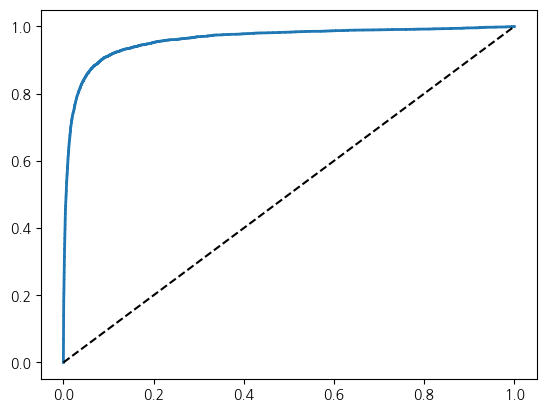

In [63]:
def plot_roc_curve(fpr, tpr, label = None):
  plt.plot(fpr, tpr, linewidth = 2, label = label)
  plt.plot([0, 1], [0, 1], 'k--') # 대각 점선

plot_roc_curve(fpr, tpr)
plt.show()

In [64]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [65]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3, method = "predict_proba")

In [66]:
y_scores_forest = y_probas_forest[:, 1] #양성 클래스에 대한 확률을 점수로 사용
fpr_forest, tpr_forest, thresfolds_forest = roc_curve(y_train_5, y_scores_forest)

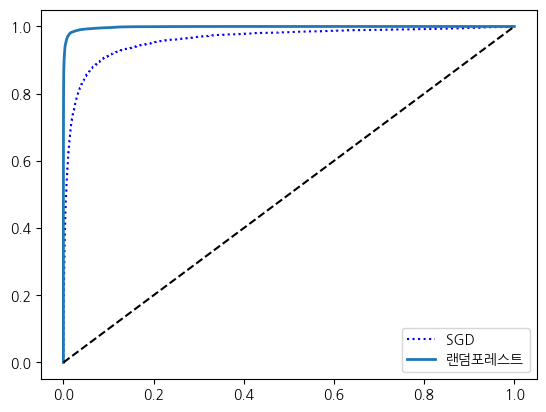

In [67]:
plt.plot(fpr, tpr, "b:", label = "SGD")
plot_roc_curve(fpr_forest, tpr_forest, "랜덤포레스트")
plt.legend(loc = "lower right")
plt.show()

In [68]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

ROC 곡선 : FPR이 변할 때 TPR이 어떻게 변하는 지를 나타낸 곡선

- TPR : True Positive Rate = 재현율, 민감도
- TNR : True Negative Rate = TN/(FP+TN)
FPR을 0에서 1까지 변경해가면서 TPR의 변화 값을 구하는데 이 때 곡선을 그리면 그게 ROC Curve  

AUC는 위에서 그린 ROC Curve의 밑의 면적으로 최댓값은 1

# 3.4 다중 분류

In [69]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train[:2000], y_train[:2000])  #이제 다중분류니까 y_train_5아니고 y_train 사용
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [70]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 3.79297828,  0.72949369,  6.06184129,  8.29800527, -0.29383983,
         9.30157597,  1.74723215,  2.77365456,  7.20601456,  4.82245092]])

In [71]:
np.argmax(some_digit_scores)

5

In [72]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [73]:
svm_clf.classes_[5]

5

In [74]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train[:2000], y_train[:2000])
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [75]:
len(ovr_clf.estimators_)

10

In [76]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [77]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [78]:
cross_val_score(sgd_clf, X_train, y_train, cv = 3, scoring = "accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [79]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train, y_train, cv = 3, scoring = "accuracy")

array([0.87365, 0.85835, 0.8689 ])

앞서서 한 분류는 모두 이진 분류, 그렇지만 실제 MNIST 데이터는 다중 레이블을 가진 다중분류임.  
따라서 여러 개의 레이블을 갖는 분류를 해내도록 모델 생성, 평가  
  
로지스틱 회귀나 서포트 벡터 머신의 경우 이진 분류만 가능하지만 다중 분류가 가능한 다른 알고리즘들 선택,  
ex) SGD, RandomForest, naive Bayes 등등  
위와 같은 다중 분류 모델은 이미지를 분류할 때 각 분류기위 결정 점수 중 가장 점수가 가장 높은 것을 클래스로 선택하면 됨!  
-> 이게 바로 OvR(= OvA) 전략이라고 부름  

or  

각 숫자의 조합마자 이진 분류를 진행, 그 조합에 대한 모든 분류를 진행시켜서 비교  
-> OvO 전략


# 3.5 에러 분석

In [81]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv = 3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

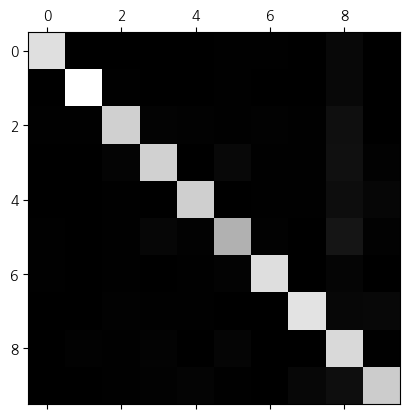

In [82]:
plt.matshow(conf_mx, cmap = plt.cm.gray)
plt.show()

In [83]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx/row_sums

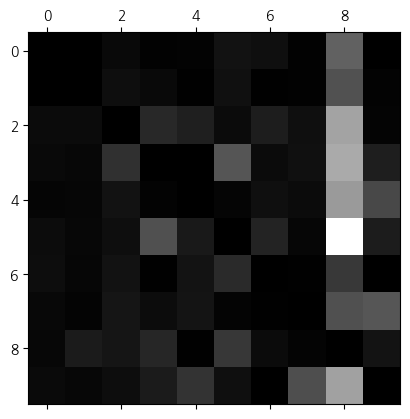

In [84]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
plt.show()

8열이 전반적으로 밝음 -> 8로 오분류된 경우가 상당히 많음!

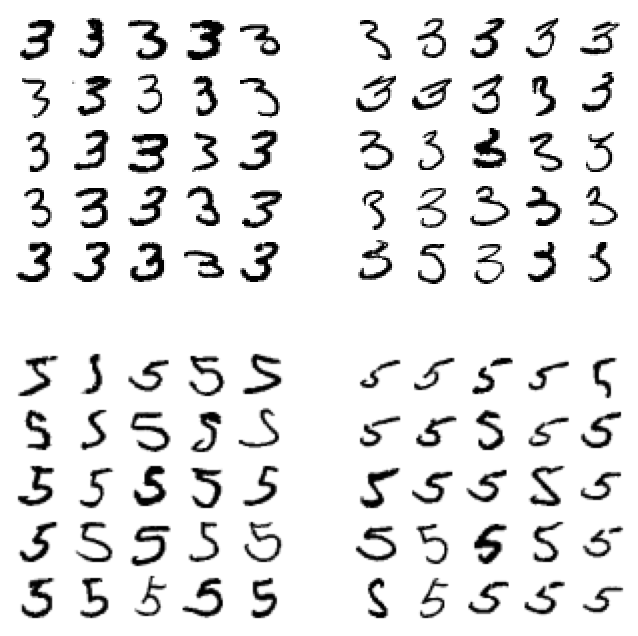

In [85]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

plt.figure(figsize = (8, 8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row = 5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row = 5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row = 5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row = 5)
plt.show()

결과를 확인하고 고쳐나가는 과정으로 오차 행렬을 살펴봐서 어떤 레이블로 오분류된 게 많은 지를 확인.  
그리고 3과 5의 경우 어떤 케이스들이 잘못 분류된건지 확인!

# 3.6 다중 레이블 분류

In [86]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train>=7)
y_train_odd = (y_train%2==1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [87]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [88]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

0.976410265560605

하나의 데이터가 여러 개의 레이블을 가질 수 있음. 이런 경우를 위해서 다중 레이블 분류를 진행 가능함.   
이 때 macro 옵션을 지정해서 기존에 이진분류에만 사용가능했던 평가 지표를 다중 분류에도 사용 가능하게 됨.

# 3.7 다중 출력 분류

In [89]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train+noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test+noise
y_train_mod = X_train
y_test_mod = X_test

분류기를 훈련시켜 깔끔한 이미지로 만듦

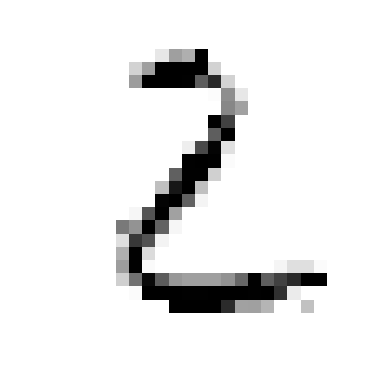

In [90]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[1]])
plot_digits(clean_digit)

노이즈가 제거되고 2와 같이 깔끔하게 생긴 이미지 출력